In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime


from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob


In [3]:
!ls /Data2/SubX/EMC/GEFS/

cape					   sty_sfc
climatology				   swe_sfc
correctedfiles.d			   ta_10
cprat_sfc				   ta_100
DJF					   ta_30
dlwrf_sfc				   ta_50
dswrf_sfc				   tas_2m
forecast				   tasmax_sfc
grb2_databefore1strecord.txt		   tasmin_sfc
grb2_large_int_byte_files.txt		   tdps_sfc
hfls_sfc				   ts_sfc
hfss_sfc				   ua_10
hlcy					   ua_100
huss_850				   ua_10m
JJA					   ua_200
originaltarfiles.d			   ua_30
pentad_climatology			   ua_50
prate_sfc				   ua_850
pr_sfc					   ulwrf_sfc
psl_sfc					   uswrf_sfc
rlut_toa				   va_10
RMM					   va_100
ROMI					   va_10m
sic_sfc					   va_200
snc_sfc					   va_30
snod_sfc				   va_50
soilw1_sfc				   va_850
soilw2_sfc				   wap_500
soilw3_sfc				   zg_10
soilw4_sfc				   zg_200
SON					   zg_30
sorted_grb2_EMC_GEFS_prob_files_final.txt  zg_50
sorted_grb2_prob_files.txt		   zg_500
sort_grb2_large_int_byte_files.txt	   zg_850
stx_sfc


In [4]:
!ls /Data2/SubX/EMC/GEFS/tdps_sfc/


1999  2001  2003  2005	2007  2009  2011  2013	2015
2000  2002  2004  2006	2008  2010  2012  2014	2016


In [5]:
!ls /Data2/SubX/EMC/GEFS/tdps_sfc/1999

01  02	03  04	05  06	07  08	09  10	11  12


In [6]:
#!ls /Data2/SubX/EMC/GEFS/tdps_sfc/1999/01

In [278]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
    print(sample_weight)

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    print(weighted_quantiles)
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        print(weighted_quantiles)
        weighted_quantiles /= weighted_quantiles[-1]
        print(weighted_quantiles)
    else:
        print(np.sum(sample_weight))
        weighted_quantiles /= np.sum(sample_weight)
        print(weighted_quantiles)
    return np.interp(quantiles, weighted_quantiles, values)

In [279]:
weighted_quantile([1, 2, 9, 3.2, 4], [0.0, 0.5, 1.], old_style=False)

[1. 1. 1. 1. 1.]
[0.5 1.5 2.5 3.5 4.5]
5.0
[0.1 0.3 0.5 0.7 0.9]


array([1. , 3.2, 9. ])

In [270]:
weighted_quantile([1, 2, 9, 3.2, 4], [0.0, 0.5, 1.], sample_weight=[2, 4, 2, 2, 1], old_style=True)

[2 4 2 1 2]
[ 1.   4.   7.   8.5 10. ]


array([1. , 2.6, 9. ])

In [268]:
np.quantile([1, 1, 2,2,2,2,9,9,3.2, 3.2, 4],q=[0.0, 0.5, 1.])

array([1., 2., 9.])

In [262]:
weighted_quantile([1, 1, 2,2, 9,9,3.2, 3.2, 4], [0.0, 0.5, 1.], old_style=True)

array([1. , 3.2, 9. ])

In [257]:
weighted_quantile([1, 2, 9, 3.2, 4], [0.0, 0.5, 1.], sample_weight=[2, 1, 2, 4, 1])

array([1. , 3.2, 9. ])

# This is my preprocessing function, which I run on each grib file

In [7]:
# def ppf2_filename(ds,filename):
#     # rename coordinates
#     ds  = ds.rename({ 'lon_0':'lon', 'lat_0':'lat', 'forecast_time0':'L'})
#     # getting start time from file name
#     ts = filename.split('_')
#     whereGEFS = ts.index('GEFS')
#     dateSstr = ts[whereGEFS+1]
#     dateS = datetime.strptime(dateSstr, '%d%b%Y')
#     ds.coords['S'] = 'S', np.atleast_1d(dateS)
    
#     # replacing L dates with integer (lead days)
#     # so that I can reduce to a fixed size
#     # BEWARE - this is a hardcoded step now, so it needs to be checked for each model
    
#     #if you comment in the two print lines, you will see how L is read by xarray from the grib file
# #     print(ds.L)
# #     print(ds.S)
#     ds.coords['L']=np.arange(0.5,35.5)

#     # select US
#     ds = ds.sel(lat=slice(42,32),lon=slice(-103+360,-90+360))
# #     print(ds)
#     return ds

L in this files is read by xarray like this

`<xarray.DataArray 'L' (L: 35)>
array([  3600000000000,   7200000000000,  10800000000000,  14400000000000,
        18000000000000,  21600000000000,  25200000000000,  28800000000000,
        32400000000000,  36000000000000,  39600000000000,  43200000000000,
        46800000000000,  50400000000000,  54000000000000,  57600000000000,
        61200000000000,  64800000000000,  68400000000000,  72000000000000,
        75600000000000,  79200000000000,  82800000000000,  86400000000000,
        90000000000000,  93600000000000,  97200000000000, 100800000000000,
       104400000000000, 108000000000000, 111600000000000, 115200000000000,
       118800000000000, 122400000000000, 126000000000000],
      dtype='timedelta64[ns]')`

however if I use wgrib2 on one file
`!wgrib2 -v /Data2/SubX/EMC/GEFS/cape/1999/06/cape_GEFS_02jun1999_00z_d01_d35_m00.grb2 `

I get something like

` 1:0:d=1999060200:CAPE Convective Available Potential Energy [J/kg]:180-0 mb above ground:1 day fcst:ENS=low-res ctl
2:46954:d=1999060200:CAPE Convective Available Potential Energy [J/kg]:180-0 mb above ground:2 day fcst:ENS=low-res ctl
3:92924:d=1999060200:CAPE Convective Available Potential Energy [J/kg]:180-0 mb above ground:3 day fcst:ENS=low-res ctl
4:139690:d=1999060200:CAPE Convective Available Potential Energy [J/kg]:180-0 mb above ground:4 day fcst:ENS=low-res ctl
5:186582:d=1999060200:CAPE Convective Available Potential Energy [J/kg]:180-0 mb above ground:5 day fcst:ENS=low-res ctl `

Let's make sure I am correctly overwriting L.

I am now using L=array([  43200000000000,  129600000000000,  216000000000000,
        302400000000000,  388800000000000,  475200000000000,
        561600000000000,  648000000000000,  734400000000000,
        820800000000000,  907200000000000,  993600000000000,
       1080000000000000, 1166400000000000, 1252800000000000,
       1339200000000000, 1425600000000000, 1512000000000000,
       1598400000000000, 1684800000000000, 1771200000000000,
       1857600000000000, 1944000000000000, 2030400000000000,
       2116800000000000, 2203200000000000, 2289600000000000,
       2376000000000000, 2462400000000000, 2548800000000000,
       2635200000000000, 2721600000000000, 2808000000000000,
       2894400000000000, 2980800000000000, 3067200000000000,
       3153600000000000, 3240000000000000, 3326400000000000,
       3412800000000000, 3499200000000000, 3585600000000000,
       3672000000000000, 3758400000000000, 3844800000000000], etc......
      dtype='timedelta64[ns]')
      
from the other models I loaded 

# Load, preprocess, append, and concatenate all the grib files. In this notebook I ran it on half of the data available.

### I will comment the code below for pr_sfc. I repeat the code for each variable separiately. I could loop it for a list of varname =[ 'pr_sfc' , ....] but I preferred keeping it separate.

In [8]:
# def ppf2_filename(ds,filename):
#     # rename coordinates
#     ds  = ds.rename({ 'lon_0':'lon', 'lat_0':'lat', 'forecast_time0':'time'})
#     # getting start time from file name
#     ts = filename.split('_')
#     print(ts)
#     whereGEFS = ts.index('GEFS')
#     dateSstr = ts[whereGEFS+1]
#     dateS = datetime.strptime(dateSstr, '%d%b%Y')
    
#     Mvalue = np.int(float(np.asarray(ts[-1][2:4])))

#     ds.coords['S'] = 'S', np.atleast_1d(dateS)
#     ds.coords['M'] = 'M', np.atleast_1d(Mvalue)
    
#     # replacing L dates with integer (lead days)
#     # so that I can reduce to a fixed size
#     # BEWARE - this is a hardcoded step now, so it needs to be checked for each model
    
#     #if you comment in the two print lines, you will see how L is read by xarray from the grib file
# #     print(ds.L)
# #     print(ds.S)
#     ds.coords['time']=np.array([  43200000000000,  129600000000000,  216000000000000,
#         302400000000000,  388800000000000,  475200000000000,
#         561600000000000,  648000000000000,  734400000000000,
#         820800000000000,  907200000000000,  993600000000000,
#        1080000000000000, 1166400000000000, 1252800000000000,
#        1339200000000000, 1425600000000000, 1512000000000000,
#        1598400000000000, 1684800000000000, 1771200000000000,
#        1857600000000000, 1944000000000000, 2030400000000000,
#        2116800000000000, 2203200000000000, 2289600000000000,
#        2376000000000000, 2462400000000000, 2548800000000000,
#        2635200000000000, 2721600000000000, 2808000000000000,
#        2894400000000000, 2980800000000000],
#       dtype='timedelta64[ns]')

#     # select US
#     ds = ds.sel(lat=slice(23,50), lon=slice(230,300))
# #     print(ds)
#     return ds

In [9]:
# ds = xr.open_dataset('/Data2/SubX/EMC/GEFS/cape/1999/01/cape_GEFS_06jan1999_00z_d01_d35_m00.grb2',
#                 engine='pynio')
# ds = ppf2_filename(ds,'/Data2/SubX/EMC/GEFS/cape/1999/01/cape_GEFS_06jan1999_00z_d01_d35_m00.grb2')
# ds

In [10]:
#!ls /Data2/SubX/EMC/GEFS/cape/1999/11

In [150]:
from glob import glob
variable_names = ['pr_sfc']

def ppf2_filename(ds,filename):
    # rename coordinates
    ds  = ds.rename({ 'lon_0':'lon', 'lat_0':'lat', 'forecast_time0':'time'})
    # getting start time from file name
    ts = filename.split('_')
    print(ts)
    whereGEFS = ts.index('GEFS')
    print(whereGEFS)
    dateSstr = ts[whereGEFS+1]
    print(dateSstr)
    dateS = datetime.strptime(dateSstr, '%d%b%Y')
    print(dateS)
    
    Mvalue = np.int(float(np.asarray(ts[-1][2:4])))

    ds.coords['S'] = 'S', np.atleast_1d(dateS)
    ds.coords['M'] = 'M', np.atleast_1d(Mvalue)
    
    ds.coords['time']=np.array([  43200000000000,  129600000000000,  216000000000000,
        302400000000000,  388800000000000,  475200000000000,
        561600000000000,  648000000000000,  734400000000000,
        820800000000000,  907200000000000,  993600000000000,
       1080000000000000, 1166400000000000, 1252800000000000,
       1339200000000000, 1425600000000000, 1512000000000000,
       1598400000000000, 1684800000000000, 1771200000000000,
       1857600000000000, 1944000000000000, 2030400000000000,
       2116800000000000, 2203200000000000, 2289600000000000,
       2376000000000000, 2462400000000000, 2548800000000000,
       2635200000000000, 2721600000000000, 2808000000000000,
       2894400000000000, 2980800000000000],
      dtype='timedelta64[ns]')

    # select US
    ds = ds.sel(lat=slice(50,23), lon=slice(230,300))
#     print(ds)
    return ds

def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
#         print(path)
        with xr.open_dataset(path, engine='pynio', chunks={}) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds, path)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
#             print(ds)
#             ds.load()
            return ds
#     print(files)
    paths = sorted(glob(files))
#     print(paths)
    datasets = [process_one_path(p) for p in paths]
    
    combined = xr.combine_by_coords(datasets)
    combined = combined.chunk({'S':4,'M':-1})
    return combined

var_l=[]
for ivx, ivar in enumerate(variable_names):
    print(ivar)
    if ivar in os.listdir('/Data2/SubX/EMC/GEFS/'):
        c_l = []
        for iy in np.arange(1999, 2017):#2017
            print(iy)
            # here we suppose we only care about the combined mean of each file;
            # you might also use indexing operations like .sel to subset datasets
            combined = read_netcdfs('/Data2/SubX/EMC/GEFS/'+ivar+'/'+np.str(iy)+'/*/*.grb2', dim=['S','M'],
                                    transform_func=ppf2_filename)
            pause
            
            c_l.append(combined)
    all_values = xr.concat(c_l, dim='S') 
    var_l.append(all_values)
# all_variables = xr.merge(var_l)

pr_sfc
1999
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm00.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm01.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm02.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm03.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm04.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm05.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/EMC/GEFS/pr', 'sfc/1999/01/pr', 'sfc', 'GEFS', '06jan1999', '00z', 'd01', 'd35', 'm06.grb2']
3
06jan1999
1999-01-06 00:00:00
['/Data2/SubX/E

KeyboardInterrupt: 

In [111]:
all_variables

<xarray.Dataset>
Dimensions:          (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * time             (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat              (lat) float32 50.0 49.0 48.0 47.0 ... 26.0 25.0 24.0 23.0
  * M                (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon              (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * S                (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-28
Data variables:
    APCP_P1_L1_GLL0  (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [112]:
all_variables = all_variables.rename({'APCP_P1_L1_GLL0':'pr_sfc'})

In [113]:
all_variables

<xarray.Dataset>
Dimensions:  (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * S        (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-21 2016-12-28
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [114]:
all_variables.load()

<xarray.Dataset>
Dimensions:  (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * S        (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-21 2016-12-28
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 1.1 1.2 1.0 ... 0.84 0.65999997 0.39

In [147]:
binv = np.arange(0,33,3)
binv[-1]+=1
climatology_85 = []
# I do this month by month, I could use the dayofyear attributes and eliminate this loop
for k, gp in all_variables.groupby('S.month'):
    # I select the 3day or week2 values
    for accu_value in (['8-10','10-12','12-14','8-14']):
        # also remember that python indices start at 0, so day 1 corresponds to 0 and day 2 to 1 and so forth.
        # so the 8th day of the forecast has index 7 and the 10th has index 9.
        # isel slice is not inclusive of the last value        
        gp1 = gp.isel(time=slice(np.int(accu_value.split('-')[0])-1, np.int(accu_value.split('-')[1])))
        gp1 = gp1.sum('time')
        # I group by 3 day bins, since the start date varies almost each year (or 4.5 times out of 6 years)
        for k2, gp2, in gp1.groupby_bins('S.day', bins=binv):
            #stack because I want to pool all data
            gp3 = gp2.stack(MS=('M','S'))
            gp4 = gp3.quantile(dim=['MS'], q=[0.15,0.33,0.5,0.667,0.85])
            #add extra dimensions
            gp4 = gp4.expand_dims(['S_start','accu_value'])
            # create string for the S, I will use year=1900 because I care about day/month only
            day_init = k2.left
            if day_init==0:
                day_init+=1
            string_date = '1900-'+np.str(gp2.S.dt.month[0].values).zfill(2)+'-'+np.str(day_init).zfill(2)
            nnn = np.datetime64(string_date)
            gp4.coords['S_start'] =  'S_start', np.atleast_1d(pd.DatetimeIndex([nnn]))
            gp4.coords['accu_value'] = 'accu_value',np.atleast_1d(accu_value)
            climatology_85.append(gp4)
all_clim = xr.combine_by_coords(climatology_85)            

In [148]:
all_clim

<xarray.Dataset>
Dimensions:     (S_start: 120, accu_value: 4, lat: 28, lon: 71, quantile: 5)
Coordinates:
  * lat         (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quantile    (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * S_start     (S_start) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
  * lon         (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * accu_value  (accu_value) object '10-12' '12-14' '8-10' '8-14'
Data variables:
    pr_sfc      (S_start, accu_value, quantile, lat, lon) float64 1.57 ... 32.42

# UNITS - This is total precipitation  for the day Kg/m2 - so It is really mm/day

# create the target date for the various accumulated values for the fix S grid I have now (about every 3 days) to then extract the corresponding days from observations

## mind that NARR acc precip time refers to the beginning of the accumulation time, and so PERSIANN data. CPC is the middle of the interval (because downloaded from IRIDL)


In [251]:
all_clim.coords['T_8-10'] = all_clim.S_start.values+np.timedelta64(7,'D')
all_clim

<xarray.Dataset>
Dimensions:     (S_start: 120, T_8-10: 120, accu_value: 4, lat: 28, lon: 71, quantile: 5)
Coordinates:
  * lat         (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quantile    (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * S_start     (S_start) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
  * lon         (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * accu_value  (accu_value) object '10-12' '12-14' '8-10' '8-14'
  * T_8-10      (T_8-10) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
    T_10-12     (S_start) datetime64[ns] 1900-01-10 1900-01-12 ... 1901-01-05
    T_12-14     (S_start) datetime64[ns] 1900-01-12 1900-01-14 ... 1901-01-07
    T_8-14      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
Data variables:
    pr_sfc      (S_start, accu_value, quantile, lat, lon) float64 1.57 ... 32.42

In [250]:
all_clim.coords['T_8-10'] = xr.where(all_clim.coords['T_8-10'].dt.year==1901, all_clim.coords['T_8-10']-np.timedelta64(1,'Y'),
                                         all_clim.coords['T_8-10'])

TypeError: Cannot get a common metadata divisor for NumPy datetime metadata [ns] and [Y] because they have incompatible nonlinear base time units

In [247]:
np.timedelta64()

numpy.timedelta64

In [242]:
all_clim.coords['T_8-10']

<xarray.DataArray 'T_8-10' (S_start: 120)>
array([1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900,
       1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900, 1900])
Coordinates:
  * S_start  (S_start) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
    T_8-10   (S_start) int64 1900 1900 1900 1900 1900 ... 1900 1900 190

In [152]:
all_clim.coords['T_10-12'] = all_clim.S_start.values+np.timedelta64(9,'D')

In [153]:
all_clim.coords['T_12-14'] = all_clim.S_start.values+np.timedelta64(11,'D')

In [154]:
all_clim.coords['T_8-14'] = all_clim.S_start+np.timedelta64(7,'D')

In [155]:
all_clim

<xarray.Dataset>
Dimensions:     (S_start: 120, accu_value: 4, lat: 28, lon: 71, quantile: 5)
Coordinates:
  * lat         (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quantile    (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * S_start     (S_start) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
  * lon         (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * accu_value  (accu_value) object '10-12' '12-14' '8-10' '8-14'
    T_8-10      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
    T_10-12     (S_start) datetime64[ns] 1900-01-10 1900-01-12 ... 1901-01-05
    T_12-14     (S_start) datetime64[ns] 1900-01-12 1900-01-14 ... 1901-01-07
    T_8-14      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
Data variables:
    pr_sfc      (S_start, accu_value, quantile, lat, lon) float64 1.57 ... 32.42

In [157]:
all_clim.nbytes/1e9

0.038174868

# MASK

In [158]:
MASK_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.SubX/'
MASK_url1 = '/.hindcast/.pr'
MASK_url2 = '/dup/.SOURCES/.Features/.Political/.World/.Countries/.the_geom/objectid/135/VALUE/rasterize/dods'
url3 = '/Y/(23N)/(50N)/RANGEEDGES/X/(130W)/(60W)/RANGEEDGES'  

i_v_u ='EMC/.GEFS'
#                'GMAO/.GEOS_V2p1',
#                'NRL/.NESM',
#                'RSMAS/.CCSM4',
#                'NCEP/.CFSv2'
              #]

ds_mask = xr.open_dataset(MASK_url+i_v_u+MASK_url1+url3+MASK_url2)
ds_mask['the_geom']=xr.where(ds_mask.the_geom!=0, 1, 0)

ds_mask = ds_mask.rename({'X':'lon', 'Y':'lat'})
ds_mask = ds_mask.isel(objectid=0, drop=True)
ds_mask.coords['lon'] = ds_mask.lon+360.



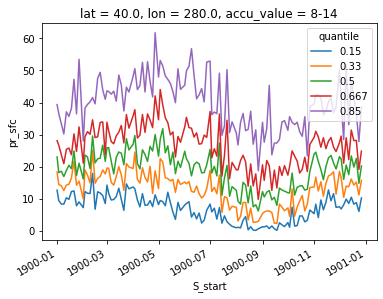

In [254]:
all_clim.pr_sfc.where(ds_mask.the_geom>0)[:,3,:,10,50].plot.line(x='S_start')
# plt.yscale('log')

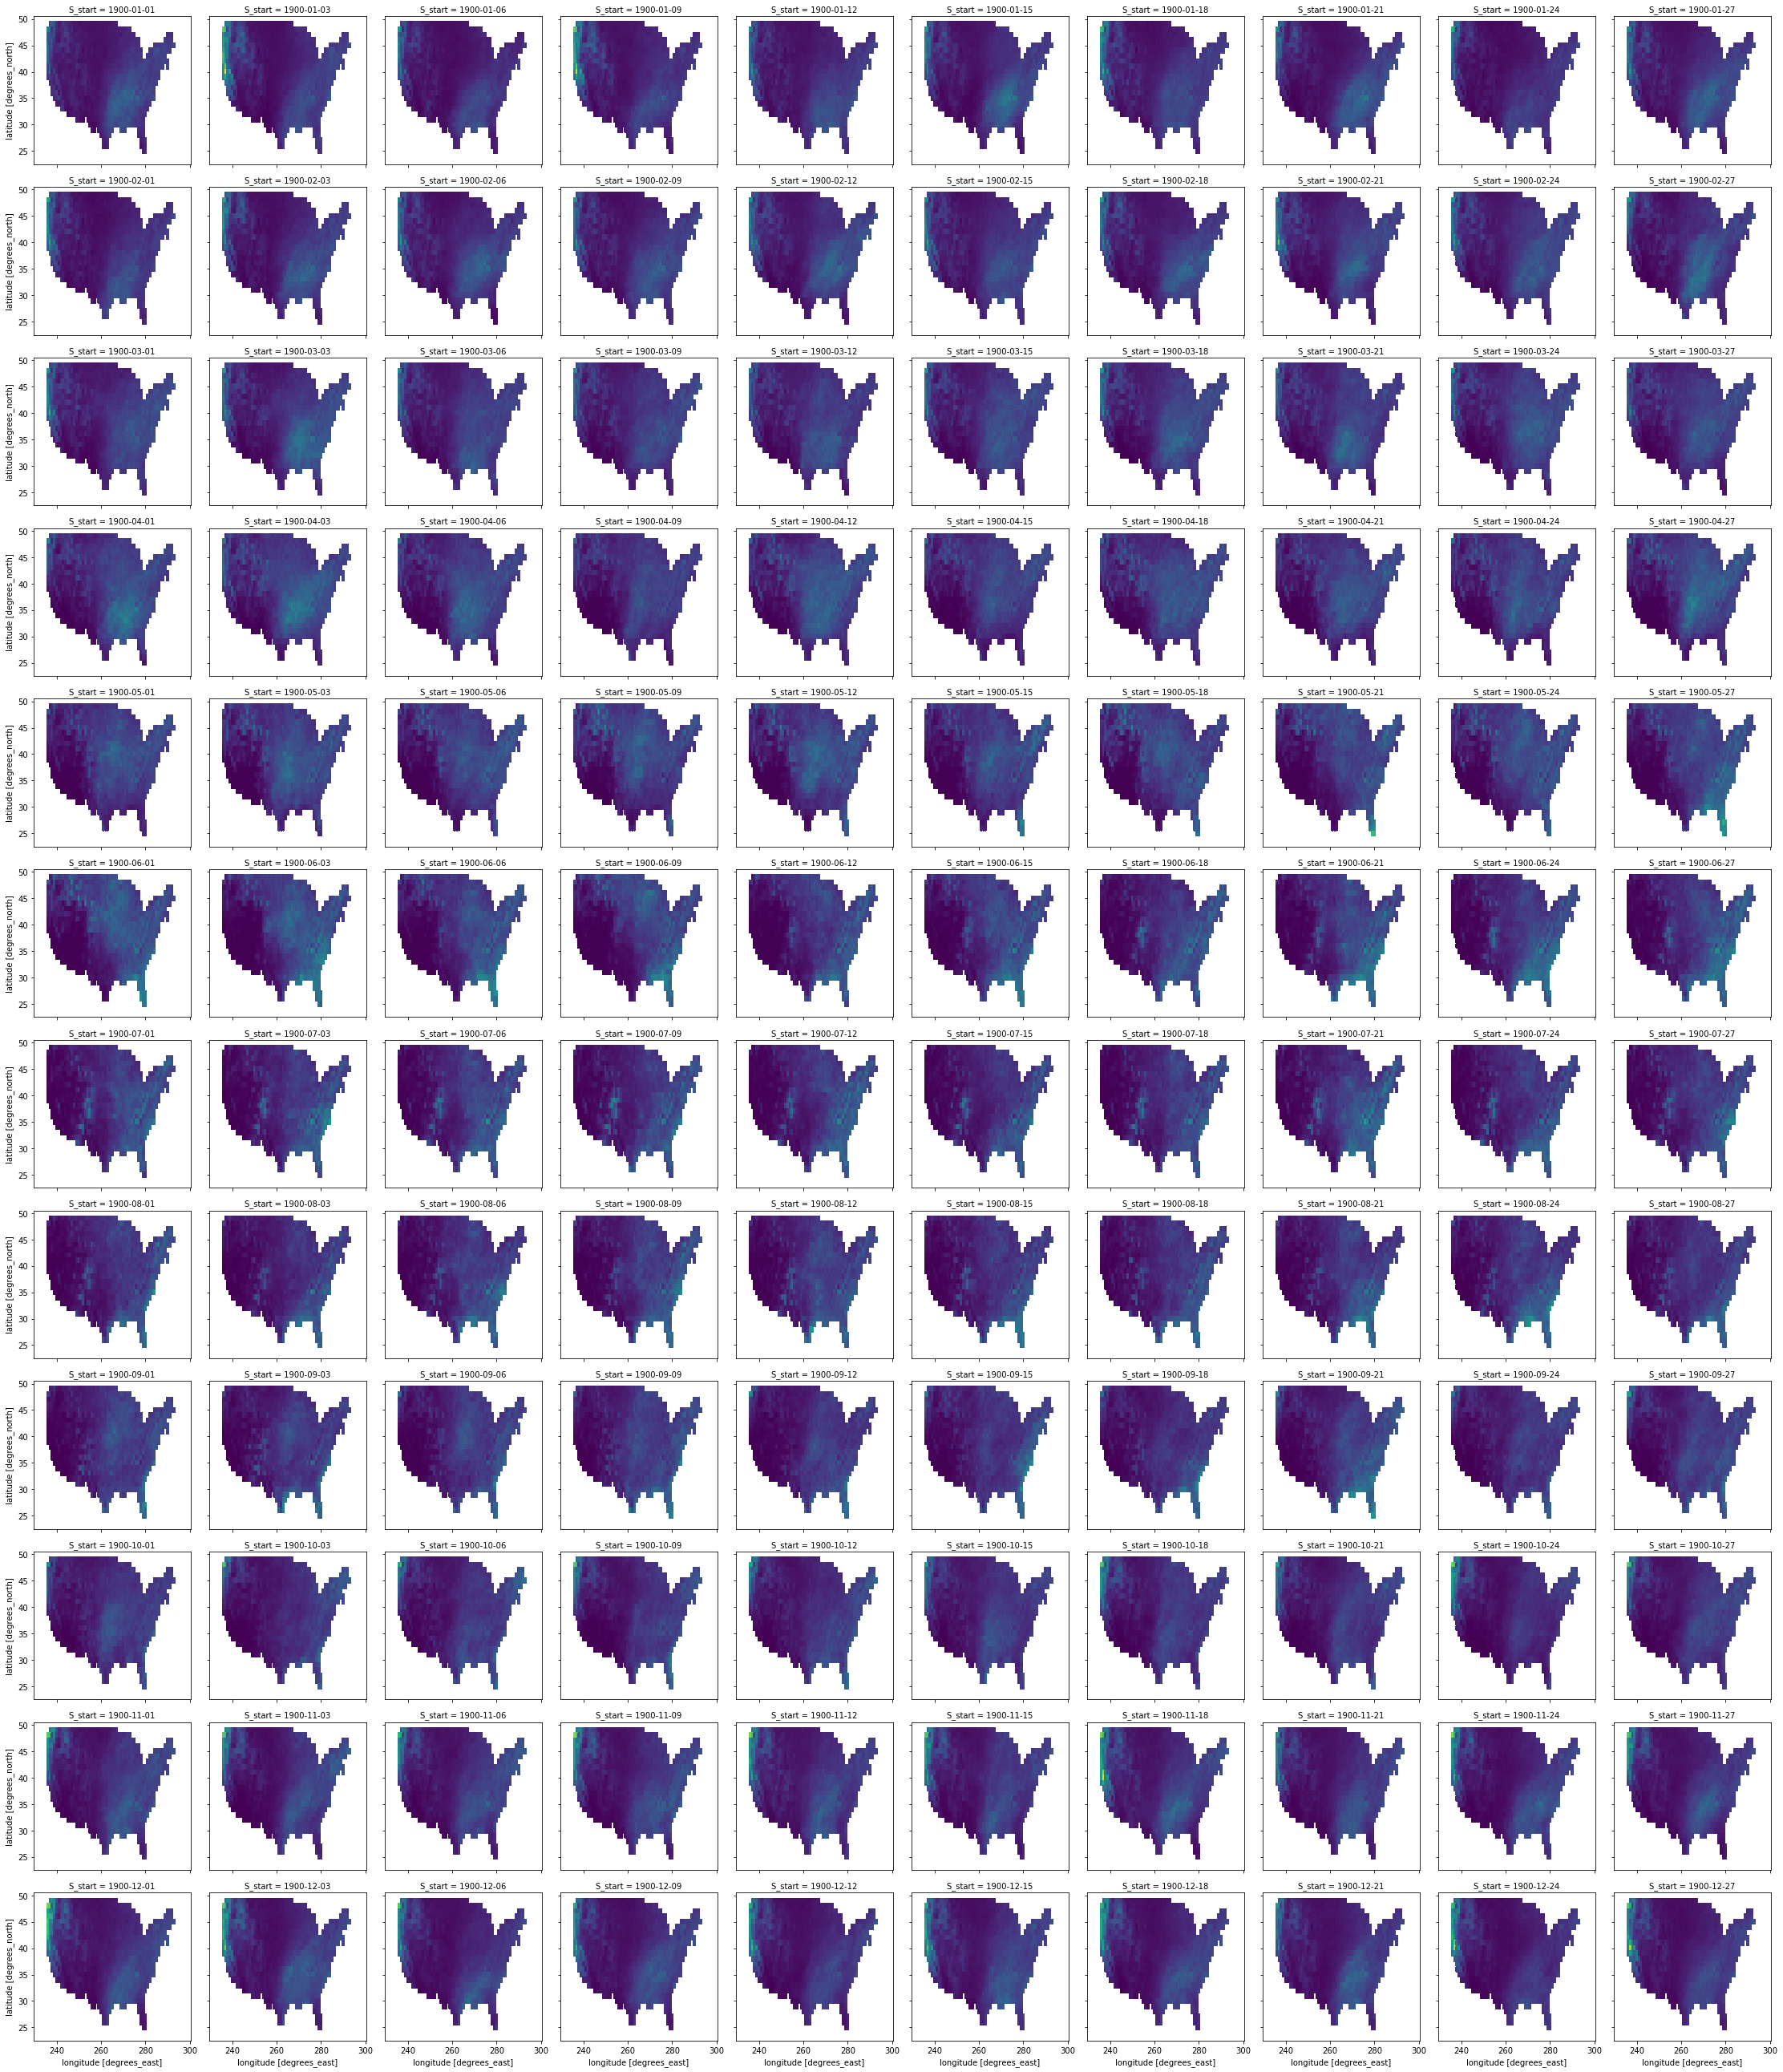

In [146]:
all_clim.pr_sfc.where(ds_mask.the_geom>0)[:,3,-1].plot(col='S_start', col_wrap=10, add_colorbar=False)

# NARR DATA

In [162]:
!ls /crunch/c0/NARR/3_hr_all/apcp/*.nc

/crunch/c0/NARR/3_hr_all/apcp/apcp.1979.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1980.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1981.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1982.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1983.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1984.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1985.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1986.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1987.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1988.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1989.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1990.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1991.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1992.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1993.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1994.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1995.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1996.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1997.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1998.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.1999.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.2000.nc
/crunch/c0/NARR/3_hr_all/apcp/apcp.2001.nc
/crunch/c0/

In [173]:
narr_ls=[]
for iy in np.arange(1999, 2017):
    temp = xr.open_dataset('/crunch/c0/NARR/3_hr_all/apcp/apcp.'+np.str(iy)+'.nc',
                          drop_variables='Lambert_Conformal')
    # aggregate to daily
    temp = temp.resample(time='1D').sum()
#     print(temp)
#     pause
    narr_ls.append(temp)
    del temp

/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.

In [174]:
narr_ls

[<xarray.Dataset>
 Dimensions:  (time: 365, x: 349, y: 277)
 Coordinates:
   * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
     lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
     lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
   * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
   * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
 Data variables:
     apcp     (time, y, x) float32 0.0016819835 0.0016819835 ... 0.0 0.0,
 <xarray.Dataset>
 Dimensions:  (time: 366, x: 349, y: 277)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
     lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
     lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
   * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
   * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0

In [175]:
narr_ds = xr.combine_by_coords(narr_ls)
temp = narr_ds.rolling(time=3, center=False).sum()

In [187]:
narr_3day_climo_ls = []
for k, temp1 in  temp.groupby('time.dayofyear'):
    string_date = '1900-'+np.str(temp1.time.dt.month[0].values).zfill(2)+'-'+np.str(temp1.time.dt.day[0].values).zfill(2)
    nnn = np.datetime64(string_date)
    print(nnn)
    temp2 = temp1.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    temp2 = temp2.expand_dims('time')
    temp2.coords['time']= 'time', np.atleast_1d(pd.DatetimeIndex([nnn]))
    narr_3day_climo_ls.append(temp2)
    
            

1900-01-01
1900-01-02
1900-01-03
1900-01-04
1900-01-05
1900-01-06
1900-01-07
1900-01-08
1900-01-09
1900-01-10
1900-01-11
1900-01-12
1900-01-13
1900-01-14
1900-01-15
1900-01-16
1900-01-17
1900-01-18
1900-01-19
1900-01-20
1900-01-21
1900-01-22
1900-01-23
1900-01-24
1900-01-25
1900-01-26
1900-01-27
1900-01-28
1900-01-29
1900-01-30
1900-01-31
1900-02-01
1900-02-02
1900-02-03
1900-02-04
1900-02-05
1900-02-06
1900-02-07
1900-02-08
1900-02-09
1900-02-10
1900-02-11
1900-02-12
1900-02-13
1900-02-14
1900-02-15
1900-02-16
1900-02-17
1900-02-18
1900-02-19
1900-02-20
1900-02-21
1900-02-22
1900-02-23
1900-02-24
1900-02-25
1900-02-26
1900-02-27
1900-02-28
1900-03-01
1900-03-02
1900-03-03
1900-03-04
1900-03-05
1900-03-06
1900-03-07
1900-03-08
1900-03-09
1900-03-10
1900-03-11
1900-03-12
1900-03-13
1900-03-14
1900-03-15
1900-03-16
1900-03-17
1900-03-18
1900-03-19
1900-03-20
1900-03-21
1900-03-22
1900-03-23
1900-03-24
1900-03-25
1900-03-26
1900-03-27
1900-03-28
1900-03-29
1900-03-30
1900-03-31
1900-04-01

In [ ]:
temp = narr_ds.rolling(time=7, center=False).sum()

In [204]:
narr_7day_climo_ls = []
for k, temp1 in  temp.groupby('time.dayofyear'):
    string_date = '1900-'+np.str(temp1.time.dt.month[0].values).zfill(2)+'-'+np.str(temp1.time.dt.day[0].values).zfill(2)
    nnn = np.datetime64(string_date)
    print(nnn)
    if nnn in all_clim['T_8-14'].S_start.values:
        temp2 = temp1.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
        temp2 = temp2.expand_dims('time')
        temp2.coords['time']= 'time', np.atleast_1d(pd.DatetimeIndex([nnn]))
        narr_7day_climo_ls.append(temp2)
    

1900-01-01
1900-01-02
1900-01-03
1900-01-04
1900-01-05
1900-01-06
1900-01-07
1900-01-08
1900-01-09
1900-01-10
1900-01-11
1900-01-12
1900-01-13
1900-01-14
1900-01-15
1900-01-16
1900-01-17
1900-01-18
1900-01-19
1900-01-20
1900-01-21
1900-01-22
1900-01-23
1900-01-24
1900-01-25
1900-01-26
1900-01-27
1900-01-28
1900-01-29
1900-01-30
1900-01-31
1900-02-01
1900-02-02
1900-02-03
1900-02-04
1900-02-05
1900-02-06
1900-02-07
1900-02-08
1900-02-09
1900-02-10
1900-02-11
1900-02-12
1900-02-13
1900-02-14
1900-02-15
1900-02-16
1900-02-17
1900-02-18
1900-02-19
1900-02-20
1900-02-21
1900-02-22
1900-02-23
1900-02-24
1900-02-25
1900-02-26
1900-02-27
1900-02-28
1900-03-01
1900-03-02
1900-03-03
1900-03-04
1900-03-05
1900-03-06
1900-03-07
1900-03-08
1900-03-09
1900-03-10
1900-03-11
1900-03-12
1900-03-13
1900-03-14
1900-03-15
1900-03-16
1900-03-17
1900-03-18
1900-03-19
1900-03-20
1900-03-21
1900-03-22
1900-03-23
1900-03-24
1900-03-25
1900-03-26
1900-03-27
1900-03-28
1900-03-29
1900-03-30
1900-03-31
1900-04-01

In [205]:
narr_3day_climo = xr.combine_by_coords(narr_3day_climo_ls)
narr_7day_climo = xr.combine_by_coords(narr_7day_climo_ls)


In [218]:
#del narr_3day_climo_ls
#del narr_7day_climo_ls
narr_7day_climo


<xarray.Dataset>
Dimensions:   (quantile: 5, time: 120, x: 349, y: 277)
Coordinates:
    lat       (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * quantile  (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * x         (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * y         (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * time      (time) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
Data variables:
    apcp      (time, quantile, y, x) float64 0.06509 0.05502 0.06596 ... 0.0 0.0

In [228]:
all_clim

<xarray.Dataset>
Dimensions:     (S_start: 120, accu_value: 4, lat: 28, lon: 71, quantile: 5)
Coordinates:
  * lat         (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quantile    (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * S_start     (S_start) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
  * lon         (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * accu_value  (accu_value) object '10-12' '12-14' '8-10' '8-14'
    T_8-10      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
    T_10-12     (S_start) datetime64[ns] 1900-01-10 1900-01-12 ... 1901-01-05
    T_12-14     (S_start) datetime64[ns] 1900-01-12 1900-01-14 ... 1901-01-07
    T_8-14      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
Data variables:
    pr_sfc      (S_start, accu_value, quantile, lat, lon) float64 1.57 ... 32.42

In [229]:
all_clim['T_8-14'].values

array(['1900-01-08T00:00:00.000000000', '1900-01-10T00:00:00.000000000',
       '1900-01-13T00:00:00.000000000', '1900-01-16T00:00:00.000000000',
       '1900-01-19T00:00:00.000000000', '1900-01-22T00:00:00.000000000',
       '1900-01-25T00:00:00.000000000', '1900-01-28T00:00:00.000000000',
       '1900-01-31T00:00:00.000000000', '1900-02-03T00:00:00.000000000',
       '1900-02-08T00:00:00.000000000', '1900-02-10T00:00:00.000000000',
       '1900-02-13T00:00:00.000000000', '1900-02-16T00:00:00.000000000',
       '1900-02-19T00:00:00.000000000', '1900-02-22T00:00:00.000000000',
       '1900-02-25T00:00:00.000000000', '1900-02-28T00:00:00.000000000',
       '1900-03-03T00:00:00.000000000', '1900-03-06T00:00:00.000000000',
       '1900-03-08T00:00:00.000000000', '1900-03-10T00:00:00.000000000',
       '1900-03-13T00:00:00.000000000', '1900-03-16T00:00:00.000000000',
       '1900-03-19T00:00:00.000000000', '1900-03-22T00:00:00.000000000',
       '1900-03-25T00:00:00.000000000', '1900-03-28

In [208]:
all_clim

<xarray.Dataset>
Dimensions:     (S_start: 120, accu_value: 4, lat: 28, lon: 71, quantile: 5)
Coordinates:
  * lat         (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quantile    (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * S_start     (S_start) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
  * lon         (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * accu_value  (accu_value) object '10-12' '12-14' '8-10' '8-14'
    T_8-10      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
    T_10-12     (S_start) datetime64[ns] 1900-01-10 1900-01-12 ... 1901-01-05
    T_12-14     (S_start) datetime64[ns] 1900-01-12 1900-01-14 ... 1901-01-07
    T_8-14      (S_start) datetime64[ns] 1900-01-08 1900-01-10 ... 1901-01-03
Data variables:
    pr_sfc      (S_start, accu_value, quantile, lat, lon) float64 1.57 ... 32.42

In [220]:
narr_3day_climo.sel(time=all_clim['T_10-12'].S_start.values)

<xarray.Dataset>
Dimensions:   (quantile: 5, time: 120, x: 349, y: 277)
Coordinates:
    lat       (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * quantile  (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * x         (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * y         (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * time      (time) datetime64[ns] 1900-01-01 1900-01-03 ... 1900-12-27
Data variables:
    apcp      (time, quantile, y, x) float64 0.01967 0.01937 0.0256 ... 0.0 0.0

In [230]:
narr_climo_gefs_time = narr_3day_climo.sel(time=all_clim['T_8-10'].values)
narr_climo_gefs_time = narr_climo_gefs_time.rename({'apcp':'apcp_8-10'})
narr_climo_gefs_time = narr_climo_gefs_time.rename({'time':'T_8-10'})

temp = narr_3day_climo.sel(time=all_clim['T_10-12'].values)
temp = temp.rename({'apcp':'apcp_10-12', 'time':'T_10-12' })
narr_climo_gefs_time = xr.merge([narr_climo_gefs_time,temp])                

temp = narr_3day_climo.sel(time=all_clim['T_12-14'].values)
temp = temp.rename({'apcp':'apcp_12-14', 'time':'T_12-14' })
narr_climo_gefs_time = xr.merge([narr_climo_gefs_time,temp]) 
                           
temp = narr_7day_climo.sel(time=all_clim['T_8-14'].values)
temp = temp.rename({'apcp':'apcp_8-14', 'time':'T_8-14' })
narr_climo_gefs_time = xr.merge([narr_climo_gefs_time,temp]) 
                           
narr_climo_gefs_time

KeyError: "not all values found in index 'time'"

In [ ]:
climatology_85 = []
# I do this month by month, I could use the dayofyear attributes and eliminate this loop
for k, gp in all_variables.groupby('S.month'):
    # I select the 3day or week2 values
    for accu_value in (['8-10','10-12','12-14','8-14']):
        # also remember that python indices start at 0, so day 1 corresponds to 0 and day 2 to 1 and so forth.
        # so the 8th day of the forecast has index 7 and the 10th has index 9.
        # isel slice is not inclusive of the last value        
        gp1 = gp.isel(time=slice(np.int(accu_value.split('-')[0])-1, np.int(accu_value.split('-')[1])))
        gp1 = gp1.sum('time')
        # I group by 3 day bins, since the start date varies almost each year (or 4.5 times out of 6 years)
        for k2, gp2, in gp1.groupby_bins('S.day', bins=binv):
            #stack because I want to pool all data
            gp3 = gp2.stack(MS=('M','S'))
            gp4 = gp3.quantile(dim=['MS'], q=[0.15,0.33,0.5,0.667,0.85])
            #add extra dimensions
            gp4 = gp4.expand_dims(['S_start','accu_value'])
            # create string for the S, I will use year=1900 because I care about day/month only
            day_init = k2.left
            if day_init==0:
                day_init+=1
            string_date = '1900-'+np.str(gp2.S.dt.month[0].values).zfill(2)+'-'+np.str(day_init).zfill(2)
            nnn = np.datetime64(string_date)
            gp4.coords['S_start'] =  'S_start', np.atleast_1d(pd.DatetimeIndex([nnn]))
            gp4.coords['accu_value'] = 'accu_value',np.atleast_1d(accu_value)
            climatology_85.append(gp4)
all_clim = xr.combine_by_coords(climatology_85)       

In [ ]:
ds_out

In [ ]:
import xesmf as xe


In [ ]:
regridder = xe.Regridder(narr_ds, ds_out, 'bilinear')


In [ ]:
# narr_ds.swap_dims({'x':'lon','y':'lat'})

In [ ]:
dr_out = regridder(narr_ds)


In [ ]:
dr_out

In [ ]:
dr_out.cape_ml[0:900].load().mean('time').plot()